In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import fpfs
import galsim
import numpy as np
import matplotlib.pylab as plt

In [90]:
class LensTransform1(object):
    def __init__(self, gamma1, gamma2, kappa, non_affine=False):
        """Initialize the transform object of 2D grids
        Args:
            gamma1 (float):     the first component of lensing shear field
            gamma2 (float):     the second component of lensing shear field
            kappa (float):      the lensing convergence field
        """
        self.s2l_mat = np.array(
            [
                [1 - kappa - gamma1, -gamma2], 
                [-gamma2, 1 - kappa + gamma1]
            ]
        )
        
        self.non_affine = non_affine
        return
    
    def transform(self, coords):
        """transform the center of pixels from lensed plane to pre-lensed plane
        Args:
            coords:   coordinates (x, y) of the pixel centers [arcsec]
        """
        
        if not self.non_affine:
            return self.s2l_mat @ coords
        
    ### TO-DO: currently hardcoded since it was a quick mock-up ####
            ### Everything below here will need tidied up ### 
        x, y = coords
        
        x_prime = (1 - self.gamma1_coord(x,y))*x - self.gamma2_coord(x,y)*y
        y_prime = (1 + self.gamma1_coord(x,y))*y - self.gamma2_coord(x,y)*x
        
        return np.array([x_prime, y_prime])
        
    def gamma1_coord(self,x,y):
        
        radial_dist = np.sqrt((x - 33)**2 + (y - 33)**2)
        rwf = (radial_dist * scale) / 1.5 #hlr
        
        return gamma1 * rwf**1
    
    def gamma2_coord(self,x,y):
        
        radial_dist = np.sqrt((x - 33)**2 + (y - 33)**2)
        rwf = (radial_dist * scale) / 1.5 #hlr
        
        return gamma2 * rwf**1

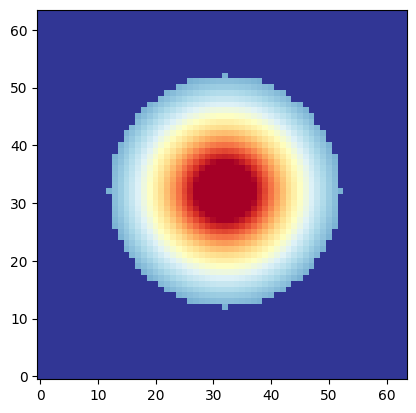

In [91]:
flux = 40
scale = 0.2
nn = 64
sersic_gal = galsim.Sersic(n=1.5, half_light_radius=1.5, flux=flux, trunc=4)
stamp = fpfs.simutil.Stamp(nn=nn, scale=scale)
gal_array = stamp.sample_galaxy(sersic_gal)
plt.close()
fpfs.pltutil.make_plot_image(gal_array)

0.06239032745361328


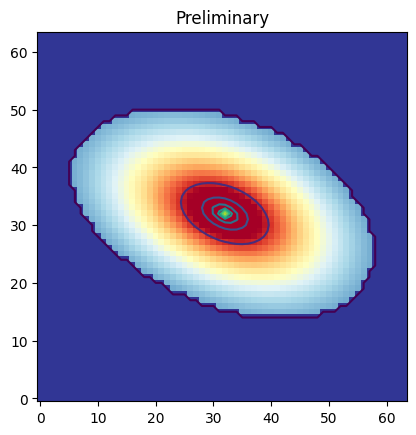

In [94]:
start = time.time()
kappa = 0.0
rwf = np.linspace(1,5,100)
gamma1 = 0.03
gamma2 = -0.03
lens = LensTransform1(gamma1=gamma1, gamma2=gamma2, kappa=kappa, non_affine=True)

stamp = fpfs.simutil.Stamp(nn=nn, scale=scale)
stamp.transform_grids(lens)
gal_array2 = stamp.sample_galaxy(sersic_gal)
plt.close()
fpfs.pltutil.make_plot_image(gal_array2)
plt.contour(gal_array2)
plt.title('Preliminary')

end = time.time()

print(end-start)

In [12]:
kappa = 0.0
gamma1 = 0.02
gamma2 = 0.0
lens = LensTransform1(gamma1=gamma1, gamma2=gamma2, kappa=kappa)
stamp = fpfs.simutil.Stamp(nn=64, scale=scale)
stamp.transform_grids(lens)
gal_array3 = stamp.sample_galaxy(sersic_gal)
psf_array = np.zeros(stamp.shape)
psf_array[nn // 2, nn // 2] = 1

coords = np.array([nn//2, nn//2])
fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.52)
mms =  fpTask.measure(gal_array3, coords)
mms = fpTask.get_results(mms)
ells=   fpfs.catalog.fpfs_m2e(mms,const=20)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp
print("input shear: %.5f" % gamma1)
print("measured shear: %.5f" % shear)

/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/10/06 13:22:33 ---  Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023/10/06 13:22:33 ---  Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023/10/06 13:22:33 ---  Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023/10/06 13:22:33 ---  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/b7009348/.local/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly reques

input shear: 0.02000
measured shear: 0.02003
